In [ ]:
#Libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import cv2

In [69]:
class windkesselModel:
    def __init__(self, bpm=60, max_flow_output=250):
        # Cardiac cycles per minute
        self.bpm = bpm

        # Period of each cardiac cycle in seconds
        self.t_bit = 60/bpm

        # Period of systole in seconds
        self.t_syst = (2/5)*self.t_bit

        # Maximum putput volume of blood for each cycle in mL
        self.max_vol_output = max_flow_output
        
        # systemic peripheral resistance in (mmHg/cm^3/sec)
        self.rp = 1.05

        # systemic characteristic resistance in (mmHg/cm^3/sec)
        self.rc = 0.057

        # systemic arterial compliance in (cm^3/mmHg)
        self.c = 1.37

        # systemic arterial intertia in (mmHg/cm^3/s^2)
        self.l = 0.0070
    
    
    """ -- FLOW EQUATIONS --"""
    
    def __flow_diff0(self,t):
        t_val = t%self.t_bit
        
        if t_val <= self.t_syst:
            return self.max_vol_output*np.sin(np.pi*t_val/self.t_syst)
        else:
            return 0
    
    def __flow_diff1(self,t):
        t_val = t%self.t_bit
        
        if t_val <= self.t_syst:
            return self.max_vol_output*(np.pi/self.t_syst)*np.cos(np.pi*t_val/self.t_syst)
        else:
            return 0

    def __flow_diff2(self,t):
        t_val = t%self.t_bit
        
        if t_val <= self.t_syst:
            return (-1)*self.max_vol_output*((np.pi/self.t_syst)**2)*np.sin(np.pi*t_val/self.t_syst)
        else:
            return 0
        
    """ -- DIFFERENTIAL EQUATIONS -- """
    
    def __func_wink2elements(self,t,v):
        dvdt = (1/self.c)*self.__flow_diff0(t) - (1/(self.rp*self.c))*v 
        return dvdt
    
    def __func_wink3elements(self,t,v):
    
        b0 = (1+self.rc/self.rp)
        b1 = self.c*self.rc
        
        a0 = 1/self.rp
        a1 = self.c
        
        dvdt = (1/a1)*(b0*self.__flow_diff0(t) + b1*self.__flow_diff1(t) - a0*v)
        return dvdt
    
    def __func_wink4elements(self,t,v):
    
        b0 = (1+self.rc/self.rp)
        b1 = self.c*self.rc + self.l/self.rp
        b2 = self.l*self.c
        
        a0 = 1/self.rp
        a1 = self.c
        
        dvdt = (1/a1)*(b0*self.__flow_diff0(t) + b1*self.__flow_diff1(t) + b2*self.__flow_diff2(t) - a0*v)
        return dvdt
    
    """ -- SOLUTION METHOD -- """
    def solve4model(self,elements=2,t0=0,tf=1,v_init=80,steps=10000):
        
        arr_t = np.linspace(t0,tf,steps)
        arr_i = np.array([self.__flow_diff0(t) for t in arr_t])
        v_init = v_init #mmHg

        if elements == 2:
            sol = solve_ivp(lambda t, v: self.__func_wink2elements(t,v),t_span=[arr_t[0],arr_t[-1]],y0=[v_init],t_eval=arr_t)
        elif elements == 3:
            sol = solve_ivp(lambda t, v: self.__func_wink3elements(t,v),t_span=[arr_t[0],arr_t[-1]],y0=[v_init],t_eval=arr_t)
        elif elements == 4:
            sol = solve_ivp(lambda t, v: self.__func_wink4elements(t,v),t_span=[arr_t[0],arr_t[-1]],y0=[v_init],t_eval=arr_t)
            
        return arr_t, sol.y[0], arr_i

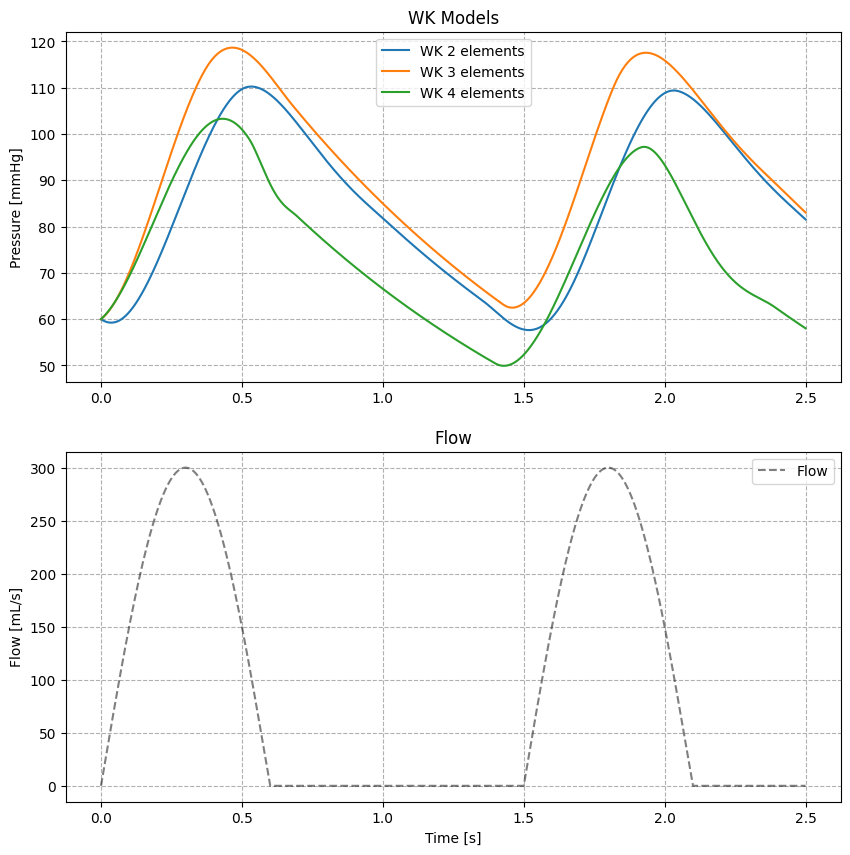

In [77]:
solutions = []

for element in np.arange(start=2,stop=5):
    solution = windkesselModel(bpm=40,max_flow_output=300).solve4model(elements=element,t0=0,tf=2.5,v_init=60)
    solutions.append(solution)

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2,1,1)
ax.plot(solutions[0][0], solutions[0][1],label='WK 2 elements')
ax.plot(solutions[0][0], solutions[1][1],label='WK 3 elements')
ax.plot(solutions[0][0], solutions[2][1],label='WK 4 elements')
ax.set_title('WK Models')
ax.grid(linestyle='--')
ax.set_ylabel('Pressure [mmHg]')
ax.legend()

ax = fig.add_subplot(2,1,2)
ax.plot(solutions[0][0], solutions[0][2],label='Flow',alpha=0.5,linestyle='--',color='black')
ax.set_title('Flow')
ax.grid(linestyle='--')
ax.set_ylabel('Flow [mL/s]')
ax.set_xlabel('Time [s]')
ax.legend()

plt.show()



## The next section demonstrate every method used step by step

### Definition of constant values

In [36]:
# Cardiac cycles per minute
bpm = 40

# Period of each cardiac cycle in seconds
t_bit = 60/bpm

# Period of systole in seconds
t_syst = (2/5)*t_bit

# Maximum putput volume of blood for each cycle in mL
max_flow_output = 300 


### Definition of flow equation

In [37]:
def flow_diff0(t):
    t_val = t%t_bit
    
    if t_val <= t_syst:
        return max_flow_output*np.sin(np.pi*t_val/t_syst)
    else:
        return 0
    
def flow_diff1(t):
    t_val = t%t_bit
    
    if t_val <= t_syst:
        return max_flow_output*(np.pi/t_syst)*np.cos(np.pi*t_val/t_syst)
    else:
        return 0

def flow_diff2(t):
    t_val = t%t_bit
    
    if t_val <= t_syst:
        return (-1)*max_flow_output*((np.pi/t_syst)**2)*np.sin(np.pi*t_val/t_syst)
    else:
        return 0

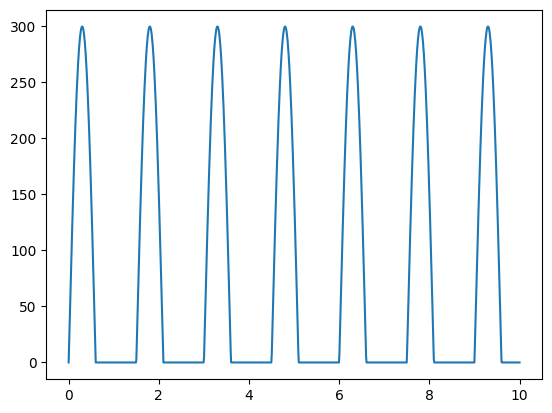

In [38]:
arr_t = np.linspace(0,10,1000)
arr_i = np.array([flow_diff0(t) for t in arr_t])

plt.plot(arr_t,arr_i)
plt.show()

In [39]:
# systemic peripheral resistance in (mmHg/cm^3/sec)
r = 0.9

# systemic arterial compliance in (cm^3/mmHg)
c = 1.0666

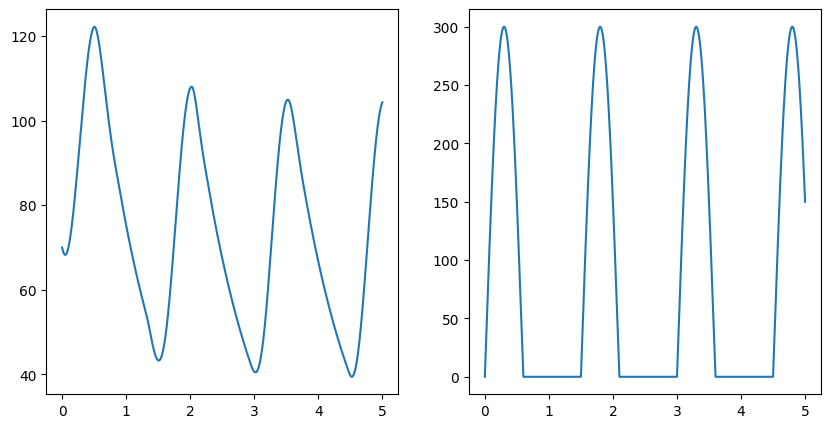

In [40]:
def func_wink2elements(t,v):
    dvdt = (1/c)*flow_diff0(t) - (1/(r*c))*v 
    return dvdt

arr_t = np.linspace(0,5,5000)
arr_i = np.array([flow_diff0(t) for t in arr_t])
v_init = 70 #mmHg

sol = solve_ivp(lambda t, v: func_wink2elements(t,v),t_span=[arr_t[0],arr_t[-1]],y0=[v_init],t_eval=arr_t)


fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(sol.t, sol.y[0])

ax = fig.add_subplot(1,2,2)
ax.plot(sol.t, arr_i)

plt.show()

In [41]:
# systemic peripheral resistance in (mmHg/cm^3/sec)
rp = 1.05

# systemic characteristic resistance in (mmHg/cm^3/sec)
rc = 0.057

# systemic arterial compliance in (cm^3/mmHg)
c = 1.37

# systemic arterial intertia in (mmHg/cm^3/s^2)
l = 0.0070

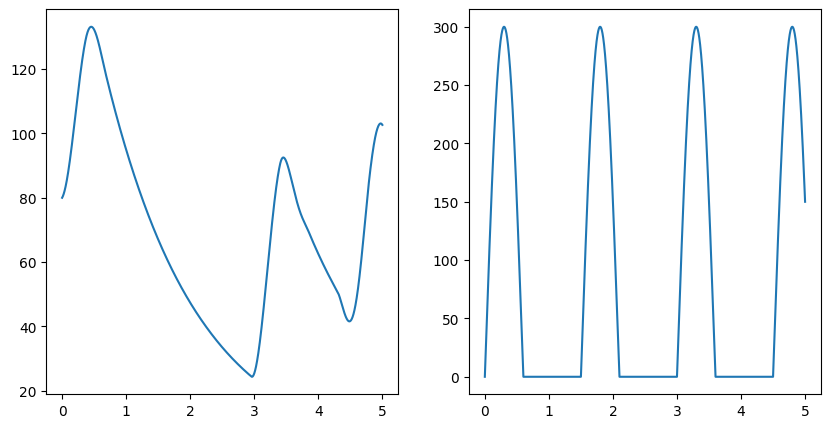

In [42]:
def func_wink3elements(t,v):
    
    b0 = (1+rc/rp)
    b1 = c*rc
    
    a0 = 1/rp
    a1 = c
    
    dvdt = (1/a1)*(b0*flow_diff0(t) + b1*flow_diff1(t) - a0*v)
    return dvdt

arr_t = np.linspace(0,5,10000)
arr_i = np.array([flow_diff0(t) for t in arr_t])
v_init = 80 #mmHg

sol = solve_ivp(lambda t, v: func_wink3elements(t,v),t_span=[arr_t[0],arr_t[-1]],y0=[v_init],t_eval=arr_t)


fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(sol.t, sol.y[0])

ax = fig.add_subplot(1,2,2)
ax.plot(sol.t, arr_i)

plt.show()

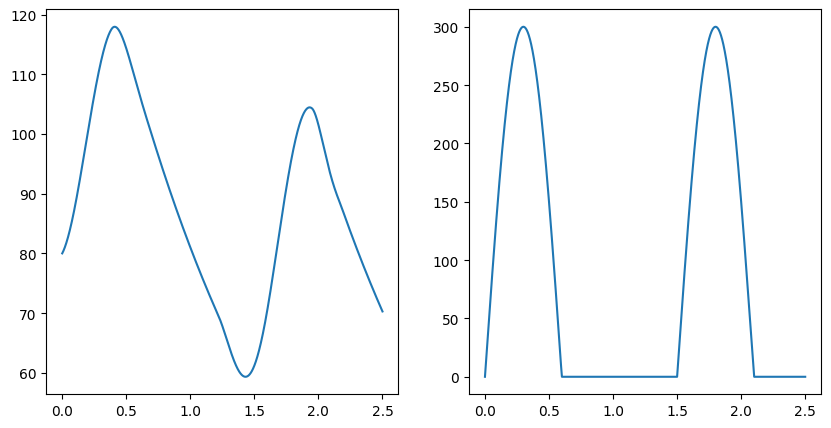

In [43]:
def func_wink4elements(t,v):
    
    b0 = (1+rc/rp)
    b1 = c*rc + l/rp
    b2 = l*c
    
    a0 = 1/rp
    a1 = c
    
    dvdt = (1/a1)*(b0*flow_diff0(t) + b1*flow_diff1(t) + b2*flow_diff2(t) - a0*v)
    return dvdt

arr_t = np.linspace(0,2.5,10000)
arr_i = np.array([flow_diff0(t) for t in arr_t])
v_init = 80 #mmHg

sol = solve_ivp(lambda t, v: func_wink4elements(t,v),t_span=[arr_t[0],arr_t[-1]],y0=[v_init],t_eval=arr_t)


fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(sol.t, sol.y[0])

ax = fig.add_subplot(1,2,2)
ax.plot(sol.t, arr_i)

plt.show()